In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from custom_dataset import CustomDataset
from collate import collate_fn
from torch import nn
import pickle
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import librosa
import sklearn
from sklearn import preprocessing
import math

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
#model.to(device)

cuda


In [2]:
def get_pkl(file_path):
    with open(file_path, 'rb') as file:
        loaded_list = pickle.load(file)
    return loaded_list

In [3]:
np_wav = get_pkl('np_wavs_cut.pkl')

In [4]:
np_wav = np_wav[:10000]

In [25]:
del np_wav 

In [5]:
str_list = get_pkl('str_list_cut.pkl')

In [6]:
str_list = str_list[:10000]

In [7]:
print(len(np_wav))
print(len(str_list))

10000
10000


In [13]:
def max_len(np_wav):    
    length = [len(x) for x in np_wav]
    
    combined_list = list(zip(length, np_wav))

    # Sort the combined list based on the elements of the first list
    sorted_list = sorted(combined_list, key=lambda x: x[0])

    # Separate the sorted elements into separate lists
    sorted_first_list, sorted_second_list = zip(*sorted_list)
    
    return sorted_first_list, sorted_second_list

In [22]:
x, y = max_len(np_wav)

NameError: name 'np_wav' is not defined

In [15]:
for i in y[-10:]:
    mfcc = librosa.feature.mfcc(y=i.astype(float), sr=24000, hop_length=512)
    print(mfcc.shape)

AttributeError: 'str' object has no attribute 'astype'

In [56]:
f, t, processed_data = signal.stft(y[3000], 24000, nperseg=1024)

# Create a new array filled with zeros of the desired shape
new_array = np.pad(processed_data, ((0, 0), (0, 939 - processed_data.shape[1])), mode='constant')

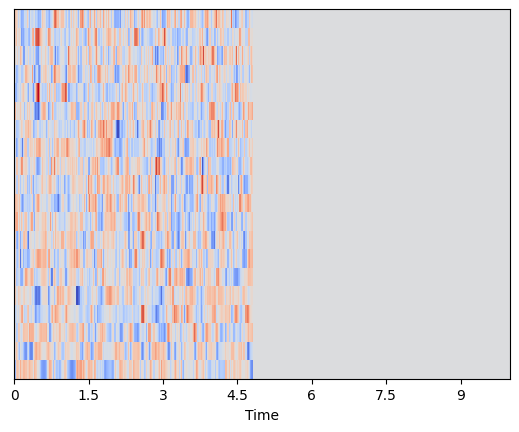

In [8]:
mfcc = librosa.feature.mfcc(y=np_wav[5].astype(float), sr=24000, hop_length=1024)
pd = sklearn.preprocessing.scale(mfcc, axis=1)
mean = np.mean(pd, axis=1, keepdims=True)
std = np.std(pd, axis=1, keepdims=True)
pd = (pd - mean) / std
new_shape = int(469)
new = np.pad(pd, ((0, 0), (0, new_shape - pd.shape[1])), mode='constant')
librosa.display.specshow(new, sr=24000, x_axis='time')

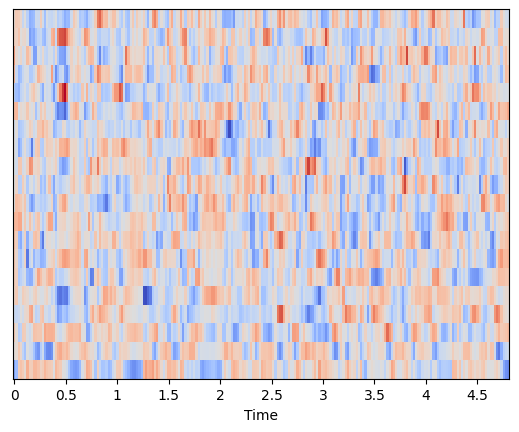

In [9]:
librosa.display.specshow(pd, sr=24000, x_axis='time')

In [15]:
new.shape

(20, 469)

In [ ]:
positional_encoding(positions, d)

In [48]:
lin = nn.Linear(469, 469, bias=False)

In [50]:
conv = nn.Conv2d(1, 64, 3, padding=(0, 1), stride=(2, 1))

In [19]:
c = torch.tensor(np.expand_dims(np.swapaxes(new,0,1), axis=0), dtype=torch.float)

In [28]:
c2 = torch.tensor(np.expand_dims(np.expand_dims(np.swapaxes(new,0,1), axis=0), axis=0), dtype=torch.float)

In [41]:
sfe = SpeechFeatureEmbedding(20)

In [42]:
output = sfe(c2)

In [54]:
output

tensor([[[ 3.7262e-01,  1.1149e+00, -1.1630e-01,  ...,  1.0858e+00,
           4.0863e-01, -2.9363e-01],
         [ 5.2365e-01,  1.1063e-01,  6.3219e-02,  ...,  4.1612e-01,
           3.7970e-01,  5.5748e-02],
         [ 8.0041e-02, -1.7216e-01,  2.5616e-01,  ..., -8.8681e-02,
           8.5591e-01,  2.1082e-04],
         ...,
         [ 6.0426e-03,  1.3562e-01, -4.4290e-02,  ...,  3.1960e-02,
           7.7187e-02, -2.0051e-02],
         [ 6.0426e-03,  1.3562e-01, -4.4290e-02,  ...,  3.1960e-02,
           7.7187e-02, -2.0051e-02],
         [ 6.0426e-03,  1.3562e-01, -4.4290e-02,  ...,  3.1960e-02,
           7.7187e-02, -2.0051e-02]]], grad_fn=<SqueezeBackward1>)

In [56]:
torch.squeeze(output, 1)

tensor([[[ 3.7262e-01,  1.1149e+00, -1.1630e-01,  ...,  1.0858e+00,
           4.0863e-01, -2.9363e-01],
         [ 5.2365e-01,  1.1063e-01,  6.3219e-02,  ...,  4.1612e-01,
           3.7970e-01,  5.5748e-02],
         [ 8.0041e-02, -1.7216e-01,  2.5616e-01,  ..., -8.8681e-02,
           8.5591e-01,  2.1082e-04],
         ...,
         [ 6.0426e-03,  1.3562e-01, -4.4290e-02,  ...,  3.1960e-02,
           7.7187e-02, -2.0051e-02],
         [ 6.0426e-03,  1.3562e-01, -4.4290e-02,  ...,  3.1960e-02,
           7.7187e-02, -2.0051e-02],
         [ 6.0426e-03,  1.3562e-01, -4.4290e-02,  ...,  3.1960e-02,
           7.7187e-02, -2.0051e-02]]], grad_fn=<SqueezeBackward1>)

In [51]:
PE = PositionalEncoding(20, dropout=0, max_len=116)

In [57]:
PE(output)

tensor([[[ 0.3726,  2.1149, -0.1163,  ...,  2.0858,  0.4086,  0.7064],
         [ 1.3651,  0.6509,  0.4509,  ...,  1.4161,  0.3799,  1.0557],
         [ 0.9893, -0.5883,  0.9709,  ...,  0.9113,  0.8564,  1.0002],
         ...,
         [-0.0911,  1.1309,  0.7992,  ...,  1.0294,  0.1056,  0.9795],
         [ 0.7910,  0.7551,  0.9415,  ...,  1.0294,  0.1058,  0.9795],
         [ 0.9515, -0.1902,  0.9296,  ...,  1.0293,  0.1061,  0.9795]]],
       grad_fn=<AddBackward0>)

In [20]:
c.shape

torch.Size([1, 469, 20])

In [53]:
out2 = conv(c)

In [54]:
out2.shape

torch.Size([64, 234, 20])

In [36]:
tens = torch.tensor(new, dtype=torch.float)

In [37]:
tens

tensor([[-2.0100, -1.4308,  0.7149,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1171,  0.2344,  0.9171,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.8863,  0.1718, -0.9830,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 1.7579,  0.3039, -0.0946,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.6065,  0.5445,  0.9783,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2840,  0.7986,  0.7165,  ...,  0.0000,  0.0000,  0.0000]])

In [49]:
out = lin(tens)

In [46]:
out.shape

torch.Size([20, 469])

In [50]:
out

tensor([[-0.2222,  0.0241, -0.0424,  ...,  0.6055,  0.5242, -0.0349],
        [ 0.3531,  0.0039, -0.3398,  ...,  0.2529, -0.7707,  0.3558],
        [-0.6315, -0.1471,  0.3263,  ..., -0.5412,  0.1078, -0.6235],
        ...,
        [ 0.0139,  0.2335,  0.5378,  ..., -0.1993,  0.4399,  0.2300],
        [ 0.7841, -0.2230, -0.5738,  ..., -0.2932,  0.0626,  0.4008],
        [-0.4723, -0.3545,  0.5281,  ..., -0.0046,  0.2679, -0.4151]],
       grad_fn=<MmBackward0>)

In [24]:
class VectorizeChar:
    def __init__(self, max_len=50):
        self.vocab = (
            ["-", "#", "<", ">"]
            + [chr(i + 96) for i in range(1, 27)]
            + [" ", ".", ",", "?"]
        )
        self.max_len = max_len
        self.char_to_idx = {}
        for i, ch in enumerate(self.vocab):
            self.char_to_idx[ch] = i

    def __call__(self, text):
        text = text.lower()
        text = text[: self.max_len - 2]
        text = "<" + text + ">"
        pad_len = self.max_len - len(text)
        return [self.char_to_idx.get(ch, 1) for ch in text] + [0] * pad_len

    def get_vocabulary(self):
        return self.vocab

In [25]:
vectorizer = VectorizeChar(400)
print("vocab size", len(vectorizer.get_vocabulary()))
print(vectorizer("hey way i got a new complaint"))

vocab size 34
[2, 11, 8, 28, 30, 26, 4, 28, 30, 12, 30, 10, 18, 23, 30, 4, 30, 17, 8, 26, 30, 6, 18, 16, 19, 15, 4, 12, 17, 23, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [26]:
vect_str_list = [vectorizer(txt) for txt in str_list]

In [11]:
dataset = CustomDataset(np_wav, vect_str_list)
dataloader = DataLoader(dataset, batch_size=256, collate_fn=collate_fn, num_workers=0) # + num thread num_workers=6,

In [12]:
def get_angles(pos, k, d):
    # START CODE HERE
    # Get i from dimension span k
    i = k//2
    # Calculate the angles using pos, i and d
    angles = pos / (np.power(10000, 2 * i / d))
    # END CODE HERE
    
    return angles

In [13]:
def positional_encoding(positions, d):
    """
    Precomputes a matrix with all the positional encodings 
    
    Arguments:
        positions (int) -- Maximum number of positions to be encoded 
        d (int) -- Encoding size 
    
    Returns:
        pos_encoding -- (1, position, d_model) A matrix with the positional encodings
    """
    # START CODE HERE
    # initialize a matrix angle_rads of all the angles 
    angle_rads = get_angles(np.arange(positions)[:, np.newaxis],
                            np.arange(d)[np.newaxis, :],
                            d)
  
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    # END CODE HERE
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return torch.tensor(pos_encoding, dtype=torch.float) # tensor

In [3]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=469):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]`` no
        """
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [4]:
PositionalEncoding(20)

PositionalEncoding(
  (dropout): Dropout(p=0.1, inplace=False)
)

In [40]:
class SpeechFeatureEmbedding(nn.Module):
    def __init__(self, embedding_dim, num_hid=64):
        super(SpeechFeatureEmbedding, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, num_hid, 3, padding=(0, 1), stride=(2, 1)),
                             nn.BatchNorm2d(num_hid),
                             nn.ReLU(),
                             nn.Conv2d(num_hid, num_hid, 3, padding=(0, 1), stride=(2, 1)),
                             nn.BatchNorm2d(num_hid),
                             nn.ReLU()
                            )
        self.conv3 = nn.Sequential(nn.Conv2d(num_hid, 1, 1, padding="same"),
                             nn.BatchNorm2d(1),
                             nn.ReLU(),
                            )
        self.lin = nn.Linear(embedding_dim, embedding_dim, bias=False)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv3(x)
        x = self.lin(x)
        return torch.squeeze(x, 1)

In [ ]:
def FullyConnected(embedding_dim, fully_connected_dim):
    return nn.Sequential(
        nn.Linear(embedding_dim, fully_connected_dim),
        nn.ReLU(),
        nn.Linear(fully_connected_dim, embedding_dim)
        )

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads, fully_connected_dim,
                 dropout_rate=0.1, layernorm_eps=1e-6):
        super(EncoderLayer, self).__init__()
        self.mha = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, dropout=dropout_rate)
        self.ffn = FullyConnected(embedding_dim, fully_connected_dim)
        self.norm1 = nn.LayerNorm(normalized_shape=embedding_dim, eps=layernorm_eps)
        self.norm2 = nn.LayerNorm(normalized_shape=embedding_dim, eps=layernorm_eps)
        self.dropout_ffn = nn.Dropout(dropout_rate)
        
    def forward(self, inputs):
        
        self_mha_output = self.mha(inputs, inputs, inputs)
        
        skip_attention = self.norm1(torch.add(inputs, self_mha_output))
        
        ffn_output = self.ffn(skip_attention)
        
        ffn_output = self.dropout_ffn(ffn_output)
        
        encoder_layer_out = self.norm2(torch.add(skip_attention, ffn_output))
        
        return encoder_layer_out        

embedding_dim = d_model
max_len = ntoken (time)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim,
               max_len, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Encoder, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        
        self.pos_encoding = PositionalEncoding(self.embedding_dim, dropout_rate, max_len) # 3
        
        self.enc_layers = [EncoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]
    
    def forward(self, inputs):
        
        #x = inputs * math.sqrt(self.embedding_dim) #
        x = pos_encoding(inputs) #
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training)
        
        return x

In [35]:
vocab_size = len(vectorizer.get_vocabulary())

In [34]:
print(vect_str_list[1])

[2, 12, 17, 30, 9, 4, 6, 23, 32, 30, 11, 8, 30, 11, 4, 7, 30, 15, 18, 18, 14, 8, 7, 30, 4, 23, 30, 23, 26, 8, 17, 23, 28, 30, 25, 8, 21, 28, 30, 16, 24, 6, 11, 30, 4, 22, 30, 11, 8, 30, 15, 18, 18, 14, 8, 7, 30, 4, 23, 30, 22, 12, 27, 23, 28, 32, 30, 15, 4, 6, 14, 12, 17, 10, 30, 4, 30, 15, 12, 23, 23, 15, 8, 30, 18, 9, 30, 23, 11, 8, 30, 10, 21, 4, 28, 17, 8, 22, 22, 31, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

внутрь декодера (не уровня) maxlen = seq_len

In [ ]:
class TokenEmbedding(nn.Module):
    def __init__(self, num_vocab=34, maxlen=400, embedding_dim=64, dropout_rate=0.1):
        super(TokenEmbedding, self).__init__()
        self.embedding_dim = embedding_dim
        self.emb = nn.Embedding(num_vocab, embedding_dim)
        self.pos_emb = PositionalEncoding(embedding_dim, dropout=0, max_len=maxlen) # d_model, dropout=0.1, max_len=469

    def forward(self, inputs):
        x = self.emb(inputs)
        x = x * math.sqrt(self.embedding_dim)
        x = self.pos_emb(x)
        return x

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, dropout=dropout_rate)
        self.mha2 = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, dropout=dropout_rate)
        self.ffn = FullyConnected(embedding_dim, fully_connected_dim)
        self.norm1 = nn.LayerNorm(normalized_shape=embedding_dim, eps=layernorm_eps)
        self.norm2 = nn.LayerNorm(normalized_shape=embedding_dim, eps=layernorm_eps)
        self.norm3 = nn.LayerNorm(normalized_shape=embedding_dim, eps=layernorm_eps)
        self.dropout_ffn = nn.Dropout(dropout_rate)
        
    def forward(self, inputs, enc_output): # look_ahead_mask !!!!
        
        self_mha1_output = self.mha1(inputs, inputs, inputs) # look_ahead_mask !!!!
        Q1 = self.norm1(torch.add(self_mha1_output, inputs))
        
        self_mha2_output = self.mha2(query=Q1, key=enc_output, value=enc_output) # look_ahead_mask ???
        skip_attention2 = self.norm2(torch.add(self_mha2_output, Q1))
        
        ffn_output = self.ffn(skip_attention2)
        drop_output = self.dropout_ffn(drop_output)
        skip3 = self.norm3(drop_output)
        
        return skip3
        

In [17]:
#print(vect_str_list[25000])

In [ ]:
def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
    """Masks the upper half of the dot product matrix in self attention.

    This prevents flow of information from future tokens to current token.
    1's in the lower triangle, counting from the lower right corner.
    """
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


In [12]:
for i, data in enumerate(dataloader):
    x, y = data
    print(i)
    print(x.shape)
    print(y.shape)

0
torch.Size([256, 1, 469, 20])
torch.Size([256, 400])
1
torch.Size([256, 1, 469, 20])
torch.Size([256, 400])
2
torch.Size([256, 1, 469, 20])
torch.Size([256, 400])
3
torch.Size([256, 1, 469, 20])
torch.Size([256, 400])
4
torch.Size([256, 1, 469, 20])
torch.Size([256, 400])
5
torch.Size([256, 1, 469, 20])
torch.Size([256, 400])
6
torch.Size([256, 1, 469, 20])
torch.Size([256, 400])
7
torch.Size([256, 1, 469, 20])
torch.Size([256, 400])
8
torch.Size([256, 1, 469, 20])
torch.Size([256, 400])
9
torch.Size([256, 1, 469, 20])
torch.Size([256, 400])
10
torch.Size([256, 1, 469, 20])
torch.Size([256, 400])
11
torch.Size([256, 1, 469, 20])
torch.Size([256, 400])
12
torch.Size([256, 1, 469, 20])
torch.Size([256, 400])
13
torch.Size([256, 1, 469, 20])
torch.Size([256, 400])
14
torch.Size([256, 1, 469, 20])
torch.Size([256, 400])
15
torch.Size([256, 1, 469, 20])
torch.Size([256, 400])
16
torch.Size([256, 1, 469, 20])
torch.Size([256, 400])
17
torch.Size([256, 1, 469, 20])
torch.Size([256, 400])
18